In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2gray, rgb2hsv
import cv2
import pandas as pd

from skimage.segmentation import felzenszwalb
from skimage import io, color, draw
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

import numpy as np
import skimage.color
import skimage.segmentation
import skimage.util
from skimage.exposure import histogram

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))


In [15]:
img = io.imread(os.path.join(
    ROOT_DIR, "data", "datasets", "roadfollower", "basic_train", "apex", "100_67_d16eb4d0-c5b2-11ed-abbd-fc4482a56b58.jpg"
))

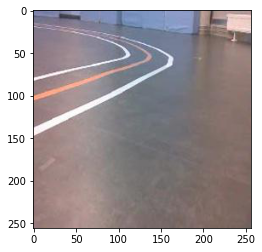

In [16]:
plt.imshow(img)

In [17]:
def draw_circle(img,x,y):
    # Create a circle mask
    mask = np.zeros_like(img[:, :, 0])
    rr, cc = draw.circle(y, x, 3, shape=mask.shape)
    mask[rr, cc] = 1

    # Apply the mask to the image
    img[mask == 1, :] = [255, 0, 0]  # Set the circle color to red
    
    return img

/tmp/ipykernel_6876/1231158059.py:4: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  rr, cc = draw.circle(y, x, 3, shape=mask.shape)


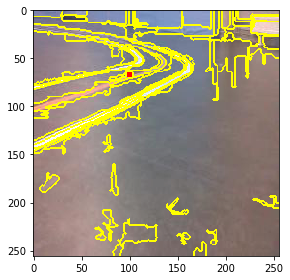

In [18]:
img = draw_circle(img, 100,67)
# segments = felzenszwalb(img, scale=500, sigma=0.5, min_size=50)
segments = felzenszwalb(img, scale=80, sigma=1, min_size=50)
io.imshow(mark_boundaries(img, segments))


In [19]:
def plot_RGB_hist(arr):
    sub_arrays = np.array_split(arr, 3)
    r = sub_arrays[0]
    g = sub_arrays[1]
    b = sub_arrays[2]
    # Plot the histograms
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    ax[0].bar(range(len(r)), r)
    ax[1].bar(range(len(g)), g)
    ax[2].bar(range(len(b)), b)
    ax[0].set_title('Red Histogram')
    ax[1].set_title('Green Histogram')
    ax[2].set_title('Blue Histogram')
    plt.show()

    
def get_segment_histogram(img, segments, segment_id, n_bins=15):
    
    # Mask for the segment
    mask = segments == segment_id
    # Extract pixels for the segment
    pixels = img[mask]
    
    lower_bound = 0
    upper_bound = 255
    bin_edges = np.linspace(lower_bound, upper_bound, n_bins+1)

    # Compute histogram on RGBs channel
    r_hist,_ = np.histogram(pixels[:, 0], bins=bin_edges, density=True)
    g_hist,_ = np.histogram(pixels[:, 1], bins=bin_edges, density=True)
    b_hist,_ = np.histogram(pixels[:, 2], bins=bin_edges, density=True)
    
    return np.concatenate([r_hist, g_hist, b_hist])


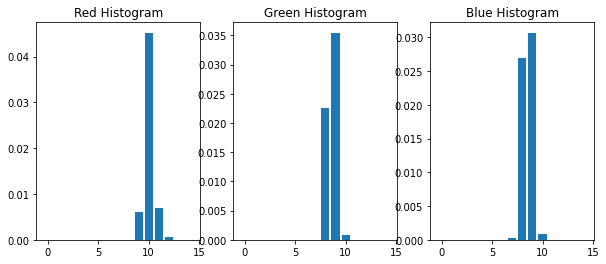

In [20]:
hist = get_segment_histogram(img, segments, 16)
plot_RGB_hist(hist)


In [21]:
from skimage.segmentation import find_boundaries

def get_connected_segments(segments, segment_label):
    # Find the boundaries of the current segment
    current_segment = segments == segment_label
    segment_boundaries = find_boundaries(current_segment, mode="outer")

    # Find the labels of the connected segments
    connected_segments = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i == 0 and j == 0:
                # Skip the current segment
                continue
            y, x = segment_boundaries.nonzero()
            y += i
            x += j
            mask = (y >= 0) & (x >= 0) & (y < segments.shape[0]) & (x < segments.shape[1])
            labels = segments[y[mask], x[mask]]
            connected_segments += list(set(labels) - {segment_label})

    # Return the list of connected segments
    return list(set(connected_segments))


In [54]:
def propagate_segment(img, segments, init_coords):
    hist_euclidian_threshold = 0.03
    y,x = init_coords
    # Mask for the segment
    mask = segments == segments[x][y]
    # Set considered segment to label -1
    segments[mask] = -1
    agg_hist = get_segment_histogram(img, segments, -1)
    
    #List containing the histograms of all aggregated segments
    hists = [agg_hist]
    
    while get_connected_segments(segments, -1):
        agg_count = 0
        #Loop through connexe segments
        for cur_seg_id in get_connected_segments(segments, -1):
            cur_hist = get_segment_histogram(img, segments, cur_seg_id)
            d = np.linalg.norm(agg_hist - cur_hist)
            if d < hist_euclidian_threshold:
                hists.append(cur_hist)
                #Add current segment to the -1 segment
                segments[segments == cur_seg_id] = -1
                #Recompute -1 segment histogram
                agg_hist = get_segment_histogram(img, segments, -1)
                agg_count += 1
        if agg_count == 0:
            break
            
    return segments, hists

In [55]:
def preview_lane(img, segment, apex):
    line_mask = segment == -1
    output_img = img.copy()
    output_img[line_mask] = [0, 255, 0]  # orange color
    output_img = draw_circle(output_img, apex[0],apex[1])
    
    io.imshow(output_img)

/tmp/ipykernel_6876/1231158059.py:4: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  rr, cc = draw.circle(y, x, 3, shape=mask.shape)


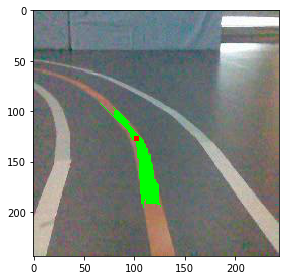

In [58]:
img = io.imread(os.path.join(
    ROOT_DIR, "data", "datasets", "roadfollower", "basic_train", "apex", "102_127_26c20d22-d398-11ed-ae7a-fc4482a56b58.jpg"
))
segments = felzenszwalb(img, scale=20, sigma=1, min_size=50)
s1, hists = propagate_segment(img, segments, (102,127))

preview_lane(img,s1,(102,127))

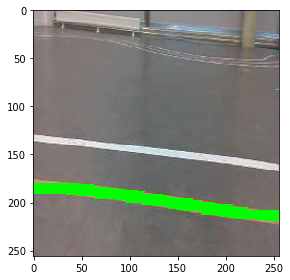

In [61]:
img = io.imread("utils/18_187.jpg")
segments = felzenszwalb(img, scale=20, sigma=1, min_size=50)
s1 = propagate_segment(img, segments, (18,187))

preview_lane(img,s1)

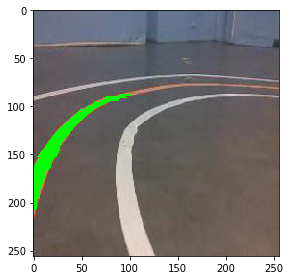

In [75]:
img = io.imread("utils/23_131.jpg")
segments = felzenszwalb(img, scale=20, sigma=1, min_size=50)
s1 = propagate_segment(img, segments, (23,131))

preview_lane(img,s1)

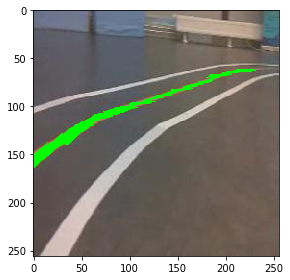

In [55]:
img = io.imread("utils/23_133.jpg")
segments = felzenszwalb(img, scale=20, sigma=1, min_size=50)
s1 = propagate_segment(img, segments, (23,140))

preview_lane(img,s1)